# <center/>同步训练和验证模型体验

## 概述

在面对复杂网络时，往往需要进行几十甚至几百次的epoch训练。而在训练之前，往往很难掌握在训练到第几个epoch时，模型的精度能达到满足要求的程度。所以经常会采用一边训练的同时，在相隔固定epoch的位置对模型进行精度验证，并保存相应的模型，等训练完毕后，通过查看对应模型精度的变化就能迅速地挑选出相对最优的模型，本文将采用这种方法，以LeNet网络为样本，进行示例。

整体流程如下：
1. 数据集准备。
2. 构建神经网络。
3. 定义回调函数EvalCallBack。
4. 定义训练网络并执行。
5. 定义绘图函数并对不同epoch下的模型精度绘制出折线图。

> 本文档适用于CPU、GPU和Ascend环境。

## 数据准备

### 数据集的下载

下载并解压数据集数据。

In [1]:
!wget https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/datasets/MNIST_Data.zip
!unzip MNIST_Data.zip
!mkdir -p ./datasets/
!mv -f ./MNIST_Data/ ./datasets/
!tree ./datasets/MNIST_Data/

--2020-11-26 11:26:02--  https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/datasets/MNIST_Data.zip
Resolving proxy-notebook.modelarts-dev-proxy.com (proxy-notebook.modelarts-dev-proxy.com)... 192.168.0.172
Connecting to proxy-notebook.modelarts-dev-proxy.com (proxy-notebook.modelarts-dev-proxy.com)|192.168.0.172|:8083... connected.
Proxy request sent, awaiting response... 200 OK
Length: 10754903 (10M) [application/zip]
Saving to: ‘MNIST_Data.zip’

MNIST_Data.zip      100%[===================>]  10.26M  62.1MB/s    in 0.2s    

2020-11-26 11:26:03 (62.1 MB/s) - ‘MNIST_Data.zip’ saved [10754903/10754903]

Archive:  MNIST_Data.zip
   creating: MNIST_Data/test/
  inflating: MNIST_Data/test/t10k-images-idx3-ubyte  
  inflating: MNIST_Data/test/t10k-labels-idx1-ubyte  
   creating: MNIST_Data/train/
  inflating: MNIST_Data/train/train-images-idx3-ubyte  
  inflating: MNIST_Data/train/train-labels-idx1-ubyte  
./datasets/MNIST_Data/
├── test
│   ├── t10k-images-idx

### 数据集的增强操作

下载下来后的数据集，需要通过`mindspore.dataset`处理成适用于MindSpore框架的数据，再使用一系列框架中提供的工具进行数据增强操作来适应LeNet网络的数据处理需求。

In [2]:
import os
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as CV
import mindspore.dataset.transforms.c_transforms as C
from mindspore.dataset.vision import Inter
from mindspore.common import dtype as mstype

def create_dataset(data_path, batch_size=32, repeat_size=1,
                   num_parallel_workers=1):
    # define dataset
    mnist_ds = ds.MnistDataset(data_path)

    # define map operations
    resize_op = CV.Resize((32, 32), interpolation=Inter.LINEAR)  
    rescale_nml_op = CV.Rescale(1 / 0.3081, -1 * 0.1307 / 0.3081) 
    rescale_op = CV.Rescale(1/255.0, 0.0) 
    hwc2chw_op = CV.HWC2CHW() 
    type_cast_op = C.TypeCast(mstype.int32) 

    # apply map operations on images
    mnist_ds = mnist_ds.map(operations=type_cast_op, input_columns="label", num_parallel_workers=num_parallel_workers)
    mnist_ds = mnist_ds.map(operations=[resize_op,rescale_op,rescale_nml_op,hwc2chw_op],
                            input_columns="image", num_parallel_workers=num_parallel_workers)

    # apply DatasetOps
    buffer_size = 10000
    mnist_ds = mnist_ds.shuffle(buffer_size=buffer_size)
    mnist_ds = mnist_ds.batch(batch_size, drop_remainder=True)
    mnist_ds = mnist_ds.repeat(repeat_size)
    
    return mnist_ds

## 构建神经网络

LeNet网络属于7层神经网络，其中涉及卷积层，全连接层，函数激活等算法，在MindSpore中都已经建成相关算子只需导入使用，如下先将卷积函数，全连接函数，权重等进行初始化，然后在LeNet5中定义神经网络并使用`construct`构建网络。

In [3]:
import mindspore.nn as nn
from mindspore.common.initializer import TruncatedNormal


def conv(in_channels, out_channels, kernel_size, stride=1, padding=0):
    """Conv layer weight initial."""
    weight = weight_variable()
    return nn.Conv2d(in_channels, out_channels,
                     kernel_size=kernel_size, stride=stride, padding=padding,
                     weight_init=weight, has_bias=False, pad_mode="valid")

def fc_with_initialize(input_channels, out_channels):
    """Fc layer weight initial."""
    weight = weight_variable()
    bias = weight_variable()
    return nn.Dense(input_channels, out_channels, weight, bias)

def weight_variable():
    """Weight initial."""
    return TruncatedNormal(0.02)

class LeNet5(nn.Cell):
    """Lenet network structure."""
    # define the operator required
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = conv(1, 6, 5)
        self.conv2 = conv(6, 16, 5)
        self.fc1 = fc_with_initialize(16 * 5 * 5, 120)
        self.fc2 = fc_with_initialize(120, 84)
        self.fc3 = fc_with_initialize(84, 10)
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

    # use the preceding operators to construct networks
    def construct(self, x):
        x = self.max_pool2d(self.relu(self.conv1(x)))
        x = self.max_pool2d(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## 定义回调函数EvalCallBack

实现思想：每隔n个epoch验证一次模型精度，需要在自定义回调函数中实现，如需了解自定义回调函数的详细用法，请参考[API说明](https://www.mindspore.cn/doc/api_python/zh-CN/master/mindspore/mindspore.train.html#mindspore.train.callback.Callback)。

核心实现：回调函数的`epoch_end`内设置验证点，如下：

`cur_epoch % eval_per_epoch == 0`：即每`eval_per_epoch`个epoch结束时，验证一次模型精度。

- `cur_epoch`：当前训练过程的`epoch`数值。
- `eval_per_epoch`：用户自定义数值，即验证频次。

其他参数解释：

- `model`：MindSpore中的`Model`类。
- `eval_dataset`：验证数据集。
- `epoch_per_eval`：记录验证模型的精度和相应的epoch数，其数据形式为`{"epoch":[],"acc":[]}`。

In [4]:
from mindspore.train.callback import Callback

class EvalCallBack(Callback):
    def __init__(self, model, eval_dataset, eval_per_epoch, epoch_per_eval):
        self.model = model
        self.eval_dataset = eval_dataset
        self.eval_per_epoch = eval_per_epoch
        self.epoch_per_eval = epoch_per_eval
        
    def epoch_end(self, run_context):
        cb_param = run_context.original_args()
        cur_epoch = cb_param.cur_epoch_num
        if cur_epoch % self.eval_per_epoch == 0:
            acc = self.model.eval(self.eval_dataset, dataset_sink_mode=False)
            self.epoch_per_eval["epoch"].append(cur_epoch)
            self.epoch_per_eval["acc"].append(acc["Accuracy"])
            print(acc)


## 定义训练网络并执行

在保存模型的参数`CheckpointConfig`中，需计算好单个`epoch`中的`step`数，根据保存模型参数`ckpt`文件时，需要间隔的`step`数来设置，本次示例每个`epoch`有1875个`step`，按照每两个`epoch`验证一次的思想，这里设置`save_checkpoint_steps=eval_per_epoch*1875`，
其中变量`eval_per_epoch`等于2。

参数解释：

- `train_data_path`：训练数据集地址。
- `eval_data_path`：验证数据集地址。
- `train_data`：训练数据集。
- `eval_data`：验证数据集。
- `net_loss`：定义损失函数。
- `net-opt`：定义优化器函数。
- `config_ck`：配置保存模型信息。
    - `save_checkpoint_steps`：每多少个step保存一次模型权重参数`ckpt`文件。
    - `keep_checkpoint_max`：设置保存模型的权重参数`cpkt`文件的数量上限。
- `ckpoint_cb`：配置模型权重参数`ckpt`文件保存名称的前缀信息及保存路径信息。
- `model`：MindSpore中的`Model`类。
- `model.train`：`Model`类的执行训练函数。
- `epoch_per_eval`：定义收集`epoch`数和对应模型精度信息的字典。

In [5]:
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor
from mindspore import context, Model
from mindspore.nn.metrics import Accuracy
from mindspore.nn.loss import SoftmaxCrossEntropyWithLogits

if __name__ == "__main__":
    context.set_context(mode=context.GRAPH_MODE, device_target="GPU")
    train_data_path = "./datasets/MNIST_Data/train"
    eval_data_path = "./datasets/MNIST_Data/test"
    ckpt_save_dir = "./lenet_ckpt"
    epoch_size = 10
    eval_per_epoch = 2
    repeat_size = 1
    network = LeNet5()
    
    train_data = create_dataset(train_data_path, repeat_size=repeat_size)
    eval_data = create_dataset(eval_data_path, repeat_size=repeat_size)
    
    # define the loss function
    net_loss = SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
    # define the optimizer
    net_opt = nn.Momentum(network.trainable_params(), learning_rate=0.01, momentum=0.9)
    config_ck = CheckpointConfig(save_checkpoint_steps=eval_per_epoch*1875, keep_checkpoint_max=15)
    ckpoint_cb = ModelCheckpoint(prefix="checkpoint_lenet", directory=ckpt_save_dir, config=config_ck)
    model = Model(network, net_loss, net_opt, metrics={"Accuracy": Accuracy()})
    
    epoch_per_eval = {"epoch": [], "acc": []}
    eval_cb = EvalCallBack(model, eval_data, eval_per_epoch, epoch_per_eval)
    
    model.train(epoch_size, train_data, callbacks=[ckpoint_cb, LossMonitor(375), eval_cb],
                dataset_sink_mode=False)

epoch: 1 step: 375, loss is 2.3103058
epoch: 1 step: 750, loss is 2.312831
epoch: 1 step: 1125, loss is 0.44688383
epoch: 1 step: 1500, loss is 0.58232707
epoch: 1 step: 1875, loss is 0.32893857
epoch: 2 step: 375, loss is 0.055930026
epoch: 2 step: 750, loss is 0.039159868
epoch: 2 step: 1125, loss is 0.043338113
epoch: 2 step: 1500, loss is 0.009982729
epoch: 2 step: 1875, loss is 0.028200757
{'Accuracy': 0.9754607371794872}
epoch: 3 step: 375, loss is 0.008095245
epoch: 3 step: 750, loss is 0.048312496
epoch: 3 step: 1125, loss is 0.005971539
epoch: 3 step: 1500, loss is 0.017642781
epoch: 3 step: 1875, loss is 0.0027953875
epoch: 4 step: 375, loss is 0.004322563
epoch: 4 step: 750, loss is 0.06779994
epoch: 4 step: 1125, loss is 0.052751977
epoch: 4 step: 1500, loss is 0.15333964
epoch: 4 step: 1875, loss is 0.012472827
{'Accuracy': 0.9852764423076923}
epoch: 5 step: 375, loss is 0.000117048636
epoch: 5 step: 750, loss is 0.027539294
epoch: 5 step: 1125, loss is 0.0015921323
epoch:

在同一目录的文件夹中可以看到`lenet_ckpt`文件夹中，保存了5个模型，和一个计算图相关数据，其结构如下：

```
lenet_ckpt
├── checkpoint_lenet-10_1875.ckpt
├── checkpoint_lenet-2_1875.ckpt
├── checkpoint_lenet-4_1875.ckpt
├── checkpoint_lenet-6_1875.ckpt
├── checkpoint_lenet-8_1875.ckpt
└── checkpoint_lenet-graph.meta
```

## 绘制不同epoch下模型的精度

定义绘图函数`eval_show`，将`epoch_per_eval`载入到`eval_show`中，绘制出不同`epoch`下模型的验证精度折线图。

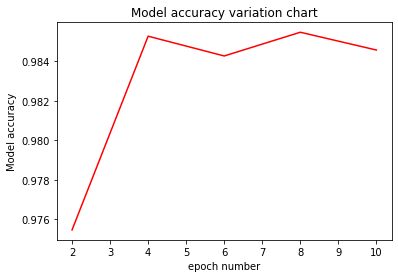

In [6]:
import matplotlib.pyplot as plt

def eval_show(epoch_per_eval):
    plt.xlabel("epoch number")
    plt.ylabel("Model accuracy")
    plt.title("Model accuracy variation chart")
    plt.plot(epoch_per_eval["epoch"], epoch_per_eval["acc"], "red")
    plt.show()
    
eval_show(epoch_per_eval)

从上图可以一目了然地挑选出需要的最优模型权重参数`ckpt`文件。

## 总结

本例使用MNIST数据集通过卷积神经网络LeNet5进行训练，着重介绍了利用回调函数在进行模型训练的同时进行模型的验证，保存对应`epoch`的模型权重参数`ckpt`文件，并从中挑选出最优模型的方法。